In [ ]:
"""
PINN for 2D Stokes Flow - Channel/Vessel Configuration
=======================================================
"""

!pip install jax jaxlib optax matplotlib

import jax
import jax.numpy as jnp
from jax import random, grad, jit, vmap
import optax
import matplotlib.pyplot as plt
import numpy as np
from functools import partial
from typing import Tuple, List, Dict, NamedTuple
import time

jax.config.update("jax_enable_x64", True)




<img src="image_stokes_1.png" width="400">

In [16]:
# =============================================================================
# Configuration
# =============================================================================

class Config(NamedTuple):
    """Problem configuration."""
    # Domain
    L: float = 2.0          # Channel length
    H: float = 0.5          # Channel height (half-width for vessel)
    
    # Physics
    mu: float = 1.0         # Dynamic viscosity
    u_max: float = 1.0      # Maximum inlet velocity
    
    # Network
    layer_sizes: Tuple = (2, 64, 64, 64, 3)
    
    # Training
    n_collocation: int = 2000
    n_boundary: int = 100
    n_epochs: int = 10000
    learning_rate: float = 1e-3
    
    # Loss weights
    """Why Different Weights?
    Boundary conditions typically need higher weights because:

    - There are fewer boundary points than interior points
    - BCs must be satisfied exactly for a physically meaningful solution
    - sPDE residuals can be small even for wrong solutions

"""
    w_pde: float = 1.0
    w_bc: float = 10.0
    w_inlet: float = 10.0
    w_outlet: float = 5.0


# =============================================================================
# Neural Network
# =============================================================================

"""Initialize MLP with Xavier initialization.
    This keeps the variance of activations roughly constant across layers,
    preventing vanishing/exploding gradients."""

def init_params(layer_sizes: Tuple, key: random.PRNGKey) -> List[Tuple]:
    params = []
    keys = random.split(key, len(layer_sizes) - 1)
    for k, n_in, n_out in zip(keys, layer_sizes[:-1], layer_sizes[1:]):
        std = jnp.sqrt(2.0 / (n_in + n_out))
        W = std * random.normal(k, (n_in, n_out))
        b = jnp.zeros(n_out)
        params.append((W, b))
    return params

""" Advantages of tanh Activation

    - Smooth & infinitely differentiable → Required for computing ∂²u/∂x²
    - Bounded output [-1, 1] → Helps with training stability
    - Zero-centered → Better gradient flow than sigmoid"""

def forward(params: List[Tuple], x: jnp.ndarray) -> jnp.ndarray:
    """MLP forward pass with tanh activation."""
    for W, b in params[:-1]:
        x = jnp.tanh(x @ W + b)
    W, b = params[-1]
    return x @ W + b


def net_uvp(params: List[Tuple], x: float, y: float) -> Tuple[float, float, float]:
    """
    Neural network predicting velocity (u, v) and pressure (p).
    
    Parameters
    ----------
    params : network parameters
    x, y : spatial coordinates
    
    Returns
    -------
    u : x-velocity
    v : y-velocity  
    p : pressure
    """
    inputs = jnp.array([x, y])
    outputs = forward(params, inputs)
    return outputs[0], outputs[1], outputs[2]


# Vectorized version for batch evaluation
# Evaluate network at many points simultaneously
# net_uvp_batch = vmap(net_uvp, in_axes=(None, 0, 0))
#                              params  x    y
#                              ↑       ↑    ↑
#                              same    batch batch

net_uvp_batch = vmap(net_uvp, in_axes=(None, 0, 0))# Parallelized, GPU-friendly



## The Physics: Stokes Equations


### From Navier-Stokes to Stokes

The governing equations for fluid fluid motion are the full Navier-Stokes equations, which include convective acceleration (inertial forces) on the left-hand side:

$$\underbrace{\rho \left( \frac{\partial \mathbf{u}}{\partial t} + \mathbf{u} \cdot \nabla \mathbf{u} \right)}_{\text{Inertia (Mass } \times \text{ Accel.)}} = \underbrace{-\nabla p}_{\text{Pressure Grad.}} + \underbrace{\mu \nabla^2 \mathbf{u}}_{\text{Viscous Forces}}$$

To determine when we can simplify these complex equations, we look at the physics of the flow regime.

### The Physics of Low Reynolds Number ($Re \ll 1$)

The Reynolds number ($Re$) acts as a referee in a tug-of-war between inertial forces (the fluid's momentum trying to keep it moving) and viscous forces (friction trying to stop it).

$$Re = \frac{\text{Inertial Forces}}{\text{Viscous Forces}} \approx \frac{\rho U L}{\mu}$$
*(Where $U$ is characteristic velocity, $L$ is characteristic length scale, $\rho$ is density, and $\mu$ is viscosity)*

The **Stokes regime** occurs when $Re \ll 1$. Physically, this means:
1.  **Viscosity Dominates:** The denominator massively overpowers the numerator. The fluid is very sticky, moving very slowly, or confined in a tiny space.
2.  **Negligible Inertia:** Momentum becomes irrelevant. The fluid has no tendency to "coast"; if the driving pressure force stops, the fluid stops instantly.

#### The Mathematical Reduction

We perform a scaling analysis to compare the magnitude of inertial terms versus viscous terms in the full equation:

$$\frac{\text{Magnitude of Inertia}}{\text{Magnitude of Viscosity}} \approx \frac{\rho U^2 / L}{\mu U / L^2} = \frac{\rho U L}{\mu} = Re$$

Because $Re \ll 1$ in this regime, the inertial terms on the left-hand side of the Navier-Stokes equation are negligible compared to the viscous terms on the right. We approximate the inertial side as zero, resulting in a balance between pressure and shear forces.

**Note on Continuity:** The continuity equation ($\nabla \cdot \mathbf{u} = 0$) remains unchanged because it represents the conservation of mass for an incompressible fluid, a property that holds true regardless of how fast or slow the fluid is moving.

### The Resulting Stokes Equations

The limiting case where inertia is ignored provides the linear Stokes equations.

**Typical Applications:**
* Blood flow in capillaries (tiny diameter $L \sim 10 \ \mu m$)
* Microfluidic devices (tiny length scales)
* Very slow viscous flows 

**Vector Form:**

$$0 = -\nabla p + \mu \nabla^2 \mathbf{u} \qquad \text{(Momentum Balance)}$$

$$\nabla \cdot \mathbf{u} = 0 \qquad \text{(Incompressibility)}$$

### In 2D Component Form

Assuming velocity vector $\mathbf{u} = (u, v)$ in the Cartesian domain:

$$
\begin{align*}
\text{X-momentum:} &\quad -\frac{\partial p}{\partial x} + \mu \left( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \right) = 0 \\[1em]
\text{Y-momentum:} &\quad -\frac{\partial p}{\partial y} + \mu \left( \frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial y^2} \right) = 0 \\[1em]
\text{Continuity:} &\quad \frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} = 0
\end{align*}
$$

<img src="image_stokes_2.png" width="600">

$\frac{\partial^2 u}{\partial x^2} = \frac{\partial}{\partial x} \left(\frac{\partial u}{\partial x}\right)$

```text
u_xx = grad(lambda x, y: grad(u_fn, 0)(x, y), 0)(x, y)
       └─────────────────────────────────────┘
                    This is ∂u/∂x
       └───────────────────────────────────────────────┘
                    Differentiate again w.r.t. x

In [8]:
# =============================================================================
# Physics Residuals (Stokes Equations)
# =============================================================================

def momentum_x_residual(params: List[Tuple], x: float, y: float, mu: float) -> float:
    """
    X-momentum residual: -∂p/∂x + μ(∂²u/∂x² + ∂²u/∂y²) = 0
    """
    u_fn = lambda x, y: net_uvp(params, x, y)[0]
    p_fn = lambda x, y: net_uvp(params, x, y)[2]
    
    # Pressure gradient
    p_x = grad(p_fn, 0)(x, y)
    
    # Laplacian of u
    u_xx = grad(lambda x, y: grad(u_fn, 0)(x, y), 0)(x, y)
    u_yy = grad(lambda x, y: grad(u_fn, 1)(x, y), 1)(x, y)
    
    return -p_x + mu * (u_xx + u_yy)


def momentum_y_residual(params: List[Tuple], x: float, y: float, mu: float) -> float:
    """
    Y-momentum residual: -∂p/∂y + μ(∂²v/∂x² + ∂²v/∂y²) = 0
    """
    v_fn = lambda x, y: net_uvp(params, x, y)[1]
    p_fn = lambda x, y: net_uvp(params, x, y)[2]
    
    # Pressure gradient
    p_y = grad(p_fn, 1)(x, y)
    
    # Laplacian of v
    v_xx = grad(lambda x, y: grad(v_fn, 0)(x, y), 0)(x, y)
    v_yy = grad(lambda x, y: grad(v_fn, 1)(x, y), 1)(x, y)
    
    return -p_y + mu * (v_xx + v_yy)


def continuity_residual(params: List[Tuple], x: float, y: float) -> float:
    """
    Continuity residual (incompressibility): ∂u/∂x + ∂v/∂y = 0
    """
    u_fn = lambda x, y: net_uvp(params, x, y)[0]
    v_fn = lambda x, y: net_uvp(params, x, y)[1]
    
    u_x = grad(u_fn, 0)(x, y)
    v_y = grad(v_fn, 1)(x, y)
    
    return u_x + v_y


def all_residuals(params: List[Tuple], x: float, y: float, mu: float) -> Tuple[float, float, float]:
    """Compute all three PDE residuals at a point."""
    r_mom_x = momentum_x_residual(params, x, y, mu)
    r_mom_y = momentum_y_residual(params, x, y, mu)
    r_cont = continuity_residual(params, x, y)
    return r_mom_x, r_mom_y, r_cont


# Vectorized residuals
all_residuals_batch = vmap(all_residuals, in_axes=(None, 0, 0, None))




<img src="image_stokes_3.png" width="500" height="300">

In [9]:
# =============================================================================
# Boundary Conditions
# =============================================================================

def parabolic_inlet_profile(y: jnp.ndarray, H: float, u_max: float) -> jnp.ndarray:
    """
    Parabolic (Poiseuille) inlet velocity profile.
    
    u(y) = u_max * (1 - (2y/H - 1)²) = u_max * 4y(H-y)/H²
    
    This gives:
    - u = 0 at y = 0 and y = H (walls)
    - u = u_max at y = H/2 (centerline)
    """
    
    y_norm = 2 * y / H - 1      # Map [0, H] → [-1, 1]
    return u_max * (1 - y_norm**2)


def generate_boundary_data(cfg: Config, key: random.PRNGKey) -> Dict[str, jnp.ndarray]:
    """
    Generate boundary condition data for channel flow.
    
    Boundaries:
    - Inlet (x=0): Parabolic velocity u(y), v=0
    - Outlet (x=L): Zero pressure gradient ∂p/∂x = 0
    - Walls (y=0, y=H): No-slip u=v=0
    """
    n = cfg.n_boundary
    
    # --- Inlet (x = 0) ---
    y_inlet = jnp.linspace(0, cfg.H, n)
    x_inlet = jnp.zeros(n)
    u_inlet = parabolic_inlet_profile(y_inlet, cfg.H, cfg.u_max)
    v_inlet = jnp.zeros(n)
    
    # --- Outlet (x = L) ---
    # We'll enforce ∂p/∂x = 0 via a soft constraint
    y_outlet = jnp.linspace(0, cfg.H, n)
    x_outlet = jnp.ones(n) * cfg.L
    
    # --- Walls ---
    # Bottom wall (y = 0)
    x_bottom = jnp.linspace(0, cfg.L, n)
    y_bottom = jnp.zeros(n)
    
    # Top wall (y = H)
    x_top = jnp.linspace(0, cfg.L, n)
    y_top = jnp.ones(n) * cfg.H
    
    return {
        'inlet': (x_inlet, y_inlet, u_inlet, v_inlet),
        'outlet': (x_outlet, y_outlet),
        'walls': (
            jnp.concatenate([x_bottom, x_top]),
            jnp.concatenate([y_bottom, y_top]),
        )
    }


def generate_collocation_points(cfg: Config, key: random.PRNGKey) -> Tuple[jnp.ndarray, jnp.ndarray]:
    """Generate random interior collocation points."""
    k1, k2 = random.split(key)
    x = random.uniform(k1, (cfg.n_collocation,), minval=0.0, maxval=cfg.L)
    y = random.uniform(k2, (cfg.n_collocation,), minval=0.0, maxval=cfg.H)
    return x, y




In [10]:
# =============================================================================
# Loss Functions
# =============================================================================

def loss_pde(params: List[Tuple], x: jnp.ndarray, y: jnp.ndarray, mu: float) -> float:
    """Physics loss: mean squared PDE residuals."""
    r_mx, r_my, r_cont = all_residuals_batch(params, x, y, mu)
    return jnp.mean(r_mx**2) + jnp.mean(r_my**2) + jnp.mean(r_cont**2)


def loss_inlet(params: List[Tuple], x: jnp.ndarray, y: jnp.ndarray, 
               u_target: jnp.ndarray, v_target: jnp.ndarray) -> float:
    """Inlet BC loss: prescribed parabolic velocity."""
    u_pred, v_pred, _ = net_uvp_batch(params, x, y)
    return jnp.mean((u_pred - u_target)**2) + jnp.mean((v_pred - v_target)**2)


def loss_outlet(params: List[Tuple], x: jnp.ndarray, y: jnp.ndarray) -> float:
    """
    Outlet BC loss: zero pressure gradient ∂p/∂x = 0.
    
    This is a Neumann condition - we enforce it by penalizing the derivative.
    """
    p_fn = lambda x, y: net_uvp(params, x, y)[2]
    
    def p_x_at_point(x, y):
        return grad(p_fn, 0)(x, y)
    
    p_x_batch = vmap(p_x_at_point)(x, y)
    return jnp.mean(p_x_batch**2)


def loss_walls(params: List[Tuple], x: jnp.ndarray, y: jnp.ndarray) -> float:
    """Wall BC loss: no-slip condition u=v=0.
    At solid walls, the fluid velocity equals the wall velocity (zero for stationary walls).
    """
    u_pred, v_pred, _ = net_uvp_batch(params, x, y)
    return jnp.mean(u_pred**2) + jnp.mean(v_pred**2)


def total_loss(params: List[Tuple], data: Dict, cfg: Config) -> Tuple[float, Dict[str, float]]:
    """
    Compute weighted total loss with individual components for monitoring.
    """
    x_coll, y_coll = data['collocation']
    x_in, y_in, u_in, v_in = data['inlet']
    x_out, y_out = data['outlet']
    x_wall, y_wall = data['walls']
    
    # Individual losses
    L_pde = loss_pde(params, x_coll, y_coll, cfg.mu)
    L_inlet = loss_inlet(params, x_in, y_in, u_in, v_in)
    L_outlet = loss_outlet(params, x_out, y_out)
    L_walls = loss_walls(params, x_wall, y_wall)
    
    # Weighted sum
    total = (cfg.w_pde * L_pde + 
             cfg.w_inlet * L_inlet + 
             cfg.w_outlet * L_outlet + 
             cfg.w_bc * L_walls)
    
    components = {
        'pde': L_pde,
        'inlet': L_inlet,
        'outlet': L_outlet,
        'walls': L_walls,
        'total': total
    }
    
    return total, components


# For gradient computation, we need a scalar-only version
def total_loss_scalar(params: List[Tuple], data: Dict, cfg: Config) -> float:
    """Scalar loss for gradient computation."""
    loss, _ = total_loss(params, data, cfg)
    return loss

<img src="image_stokes_4.png" width="500" height="300">

In [ ]:
# =============================================================================
# Training
# =============================================================================

@partial(jit, static_argnums=(3, 4))# @jit: Compiles the function to XLA (runs on GPU if available)
                                    # static_argnums=(3,): Tells JAX that cfg doesn't change (can be traced once)
def train_step(params, opt_state, data, cfg, optimizer):
    """Single JIT-compiled training step."""
    loss, grads = jax.value_and_grad(total_loss_scalar)(params, data, cfg)# Computes both the loss value and its gradients in one pass
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss


def train(cfg: Config, key: random.PRNGKey) -> Tuple[List[Tuple], List[Dict]]:
    """
    Train the PINN for channel Stokes flow.
    """
    print("="*70)
    print("PINN for 2D Stokes Channel Flow (Blood Vessel Model)")
    print("="*70)
    print(f"Domain: [0, {cfg.L}] × [0, {cfg.H}]")
    print(f"Viscosity: μ = {cfg.mu}")
    print(f"Max inlet velocity: u_max = {cfg.u_max}")
    print(f"Network: {cfg.layer_sizes}")
    print(f"Collocation points: {cfg.n_collocation}")
    print(f"Loss weights: PDE={cfg.w_pde}, Inlet={cfg.w_inlet}, "
          f"Outlet={cfg.w_outlet}, Walls={cfg.w_bc}")
    print("="*70)
    
    # Initialize network
    key, subkey = random.split(key)
    params = init_params(cfg.layer_sizes, subkey)
    n_params = sum(w.size + b.size for w, b in params)
    print(f"Total parameters: {n_params}")
    
    # Generate boundary data (fixed)
    key, subkey = random.split(key)
    bc_data = generate_boundary_data(cfg, subkey)
    
    # Optimizer with learning rate schedule
    #This gradually reduces the learning rate, helping the network converge to a precise solution.
    schedule = optax.exponential_decay(cfg.learning_rate, 2000, 0.9) #
    optimizer = optax.adam(schedule)
    opt_state = optimizer.init(params)
    
    history = []
    t0 = time.time()
    
    for epoch in range(cfg.n_epochs):
        """Resample collocation points each epoch
            - Better coverage of the domain
            - Prevents overfitting to specific locations
            - Acts as a form of regularization  
        """
        key, subkey = random.split(key)
        x_coll, y_coll = generate_collocation_points(cfg, subkey)
        
        data = {
            'collocation': (x_coll, y_coll),
            'inlet': bc_data['inlet'],
            'outlet': bc_data['outlet'],
            'walls': bc_data['walls']
        }
        
        # Training step
        params, opt_state, loss = train_step(params, opt_state, data, cfg, optimizer)
        
        # Logging
        if (epoch + 1) % 500 == 0 or epoch == 0:
            _, components = total_loss(params, data, cfg)
            history.append(components)
            
            elapsed = time.time() - t0
            print(f"Epoch {epoch+1:5d} | "
                  f"Total: {components['total']:.4e} | "
                  f"PDE: {components['pde']:.4e} | "
                  f"Inlet: {components['inlet']:.4e} | "
                  f"Walls: {components['walls']:.4e} | "
                  f"Time: {elapsed:.1f}s")
    
    print("="*70)
    print("Training complete!")
    print("="*70)
    
    return params, history






In [ ]:
# =============================================================================
# Verification & Visualization
# =============================================================================

def verify_solution(params: List[Tuple], cfg: Config):
    """
    Verify physical constraints as specified in the plan:
    1. Divergence magnitude should approach zero (|∇·u| < 1e-3)
    2. Velocity at walls should approach zero (no-slip)
    3. Inlet profile should match prescribed parabolic shape
    """
    print("\n" + "="*70)
    print("VERIFICATION")
    print("="*70)
    
    # 1. Check divergence (incompressibility)
    x_test = jnp.linspace(0.1, cfg.L - 0.1, 30)
    y_test = jnp.linspace(0.1, cfg.H - 0.1, 30)
    X, Y = jnp.meshgrid(x_test, y_test)
    x_flat, y_flat = X.flatten(), Y.flatten()
    
    div_fn = lambda x, y: continuity_residual(params, x, y)
    div_batch = vmap(div_fn)
    div_vals = div_batch(x_flat, y_flat)
    
    mean_div = jnp.mean(jnp.abs(div_vals))
    max_div = jnp.max(jnp.abs(div_vals))
    
    div_ok = max_div < 1e-3
    print(f"1. Divergence (∇·u ≈ 0):")
    print(f"   Mean |∇·u|: {mean_div:.6e}")
    print(f"   Max  |∇·u|: {max_div:.6e}")
    print(f"   Status: {'✓ PASS' if div_ok else '✗ FAIL'} (threshold: 1e-3)")

    
    # 2. Check no-slip at walls
    x_wall = jnp.linspace(0.1, cfg.L - 0.1, 50)
    y_bottom = jnp.zeros(50)
    y_top = jnp.ones(50) * cfg.H
    
    u_bot, v_bot, _ = net_uvp_batch(params, x_wall, y_bottom)
    u_top, v_top, _ = net_uvp_batch(params, x_wall, y_top)
    
    wall_error = jnp.max(jnp.array([
        jnp.max(jnp.abs(u_bot)), jnp.max(jnp.abs(v_bot)),
        jnp.max(jnp.abs(u_top)), jnp.max(jnp.abs(v_top))
    ]))
    
    wall_ok = wall_error < 1e-2
    print(f"\n2. No-slip at walls (u=v=0):")
    print(f"   Max |velocity| at walls: {wall_error:.6e}")
    print(f"   Status: {'✓ PASS' if wall_ok else '✗ FAIL'} (threshold: 1e-2)")
    
    
    # 3. Check inlet profile
    y_inlet = jnp.linspace(0, cfg.H, 50)
    x_inlet = jnp.zeros(50)
    u_inlet_pred, v_inlet_pred, _ = net_uvp_batch(params, x_inlet, y_inlet)
    u_inlet_exact = parabolic_inlet_profile(y_inlet, cfg.H, cfg.u_max)
    
    inlet_error = jnp.sqrt(jnp.mean((u_inlet_pred - u_inlet_exact)**2))
    inlet_ok = inlet_error < 1e-2
    
    print(f"\n3. Inlet parabolic profile:")
    print(f"   RMS error vs prescribed: {inlet_error:.6e}")
    print(f"   Status: {'✓ PASS' if inlet_ok else '✗ FAIL'} (threshold: 1e-2)")
    
    # Overall
    all_pass = div_ok and wall_ok and inlet_ok
    print(f"\n{'='*70}")
    print(f"OVERALL: {'✓ ALL TESTS PASSED' if all_pass else '✗ SOME TESTS FAILED'}")
    print(f"{'='*70}\n")
    
    return all_pass


def plot_results(params: List[Tuple], cfg: Config, save_prefix: str = "stokes_channel"):
    """
    Visualize the PINN solution:
    - Velocity magnitude field
    - Pressure distribution
    - Streamlines
    - Inlet profile comparison
    """
    # Evaluation grid
    nx, ny = 100, 50
    x = jnp.linspace(0, cfg.L, nx)
    y = jnp.linspace(0, cfg.H, ny)
    X, Y = jnp.meshgrid(x, y)
    x_flat, y_flat = X.flatten(), Y.flatten()
    
    # Evaluate network
    U, V, P = net_uvp_batch(params, x_flat, y_flat)
    U = np.array(U.reshape(ny, nx))
    V = np.array(V.reshape(ny, nx))
    P = np.array(P.reshape(ny, nx))
    vel_mag = np.sqrt(U**2 + V**2)
    
    X_np, Y_np = np.array(X), np.array(Y)
    
    # Create figure
    fig, axes = plt.subplots(2, 2, figsize=(14, 8))
    
    # 1. Velocity magnitude
    ax = axes[0, 0]
    c = ax.contourf(X_np, Y_np, vel_mag, levels=50, cmap='viridis')
    plt.colorbar(c, ax=ax, label='|u| [m/s]')
    ax.set_title('Velocity Magnitude')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_aspect('equal')
    
    # 2. Pressure field
    ax = axes[0, 1]
    c = ax.contourf(X_np, Y_np, P, levels=50, cmap='RdBu_r')
    plt.colorbar(c, ax=ax, label='p [Pa]')
    ax.set_title('Pressure Field')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_aspect('equal')
    
    # 3. Streamlines
    ax = axes[1, 0]
    strm = ax.streamplot(np.array(x), np.array(y), U, V, 
                         color=vel_mag, cmap='viridis', density=2, linewidth=1)
    plt.colorbar(strm.lines, ax=ax, label='|u|')
    ax.set_title('Streamlines')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_xlim(0, cfg.L)
    ax.set_ylim(0, cfg.H)
    ax.set_aspect('equal')
    
    # 4. Inlet velocity profile comparison
    ax = axes[1, 1]
    y_profile = np.linspace(0, cfg.H, 100)
    x_profile = np.zeros(100)
    u_pred, _, _ = net_uvp_batch(params, jnp.array(x_profile), jnp.array(y_profile))
    u_exact = parabolic_inlet_profile(jnp.array(y_profile), cfg.H, cfg.u_max)
    
    ax.plot(np.array(u_pred), y_profile, 'b-', lw=2, label='PINN')
    ax.plot(np.array(u_exact), y_profile, 'r--', lw=2, label='Prescribed (Poiseuille)')
    ax.set_xlabel('u(y)')
    ax.set_ylabel('y')
    ax.set_title('Inlet Velocity Profile')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.suptitle('PINN Solution: 2D Stokes Channel Flow', fontsize=14)
    plt.tight_layout()
    
    filename = f'{save_prefix}_results.png'
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    print(f"Saved: {filename}")
    plt.show()
    
    # Additional: Residual plots for debugging
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    r_mx, r_my, r_cont = all_residuals_batch(params, x_flat, y_flat, cfg.mu)
    R_mx = np.array(r_mx.reshape(ny, nx))
    R_my = np.array(r_my.reshape(ny, nx))
    R_cont = np.array(r_cont.reshape(ny, nx))
    
    for ax, data, title in zip(axes, [R_mx, R_my, R_cont], 
                                ['X-Momentum Residual', 'Y-Momentum Residual', 'Continuity Residual']):
        c = ax.contourf(X_np, Y_np, np.abs(data), levels=50, cmap='hot')
        plt.colorbar(c, ax=ax)
        ax.set_title(f'{title}\n(max: {np.abs(data).max():.2e})')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_aspect('equal')
    
    plt.suptitle('PDE Residuals (should be small everywhere)', fontsize=12)
    plt.tight_layout()
    
    filename = f'{save_prefix}_residuals.png'
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    print(f"Saved: {filename}")
    plt.show()




PINN for 2D Stokes Channel Flow (Blood Vessel Model)
Domain: [0, 2.0] × [0, 0.5]
Viscosity: μ = 1.0
Max inlet velocity: u_max = 1.0
Network: (2, 64, 64, 64, 3)
Collocation points: 2000
Loss weights: PDE=1.0, Inlet=10.0, Outlet=5.0, Walls=10.0
Total parameters: 8707
Epoch     1 | Total: 4.4857e+00 | PDE: 4.2495e-01 | Inlet: 3.5491e-01 | Walls: 4.7204e-02 | Time: 4.3s
Epoch   500 | Total: 8.8666e-01 | PDE: 2.0467e-01 | Inlet: 5.2778e-02 | Walls: 1.5295e-02 | Time: 89.5s
Epoch  1000 | Total: 2.1422e-01 | PDE: 1.2716e-01 | Inlet: 2.7760e-03 | Walls: 5.8780e-03 | Time: 170.0s
Epoch  1500 | Total: 1.5018e-01 | PDE: 8.6053e-02 | Inlet: 1.9035e-03 | Walls: 4.4911e-03 | Time: 253.5s
Epoch  2000 | Total: 9.8041e-02 | PDE: 4.6585e-02 | Inlet: 5.0009e-04 | Walls: 4.6429e-03 | Time: 347.2s
Epoch  2500 | Total: 7.5873e-02 | PDE: 3.3582e-02 | Inlet: 5.8124e-04 | Walls: 3.6435e-03 | Time: 440.1s
Epoch  3000 | Total: 6.9419e-02 | PDE: 3.1632e-02 | Inlet: 4.5426e-04 | Walls: 3.3018e-03 | Time: 530.8s
Ep

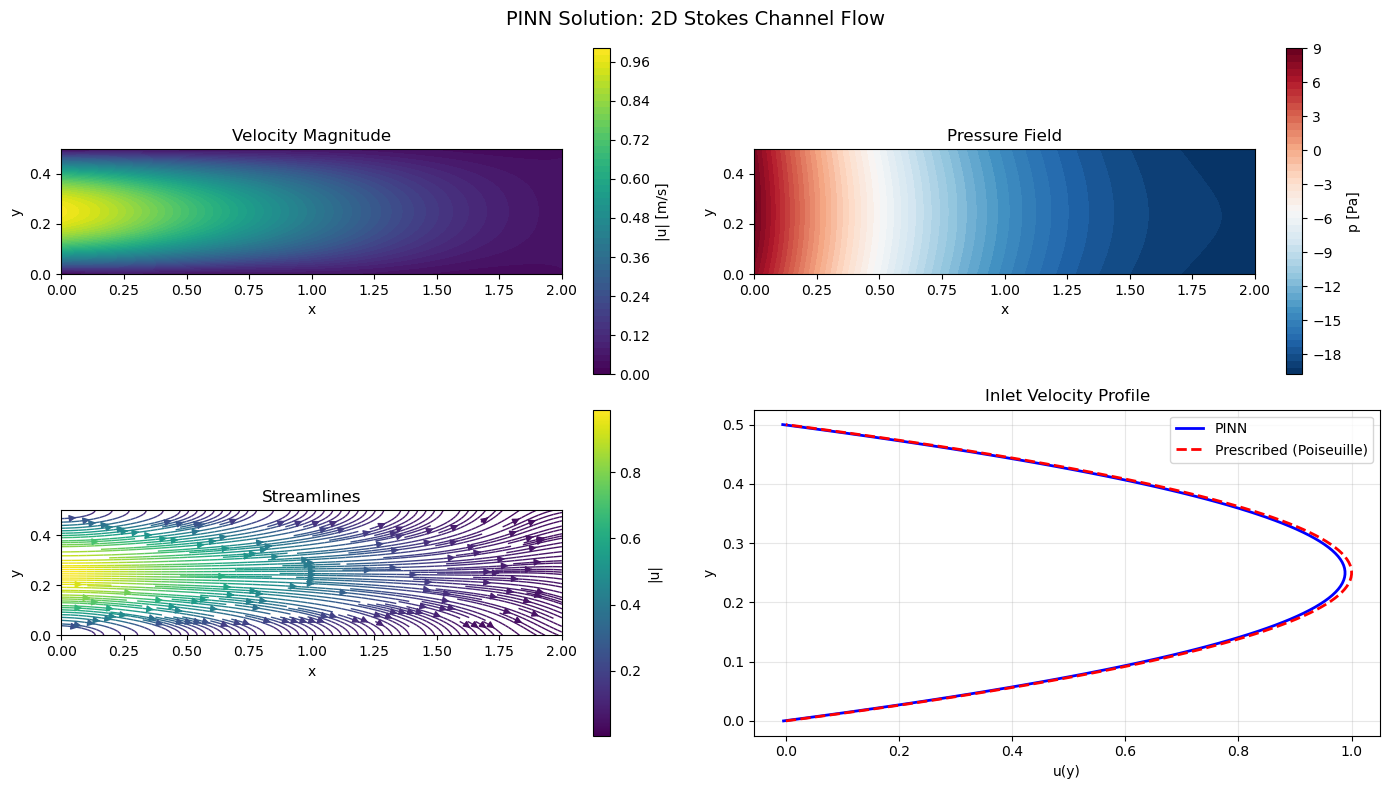

Saved: stokes_channel_residuals.png


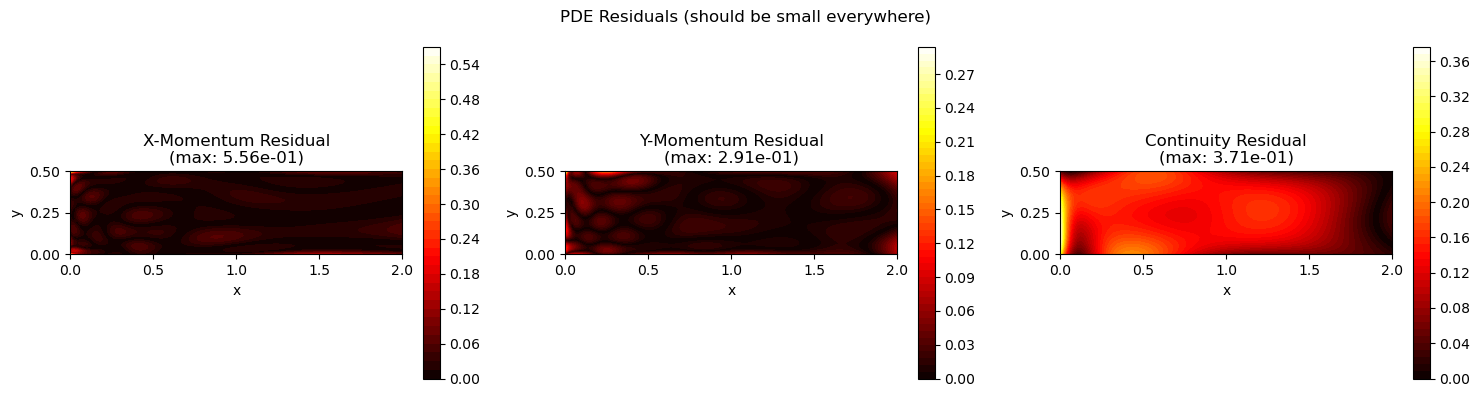

Saved: stokes_channel_training.png


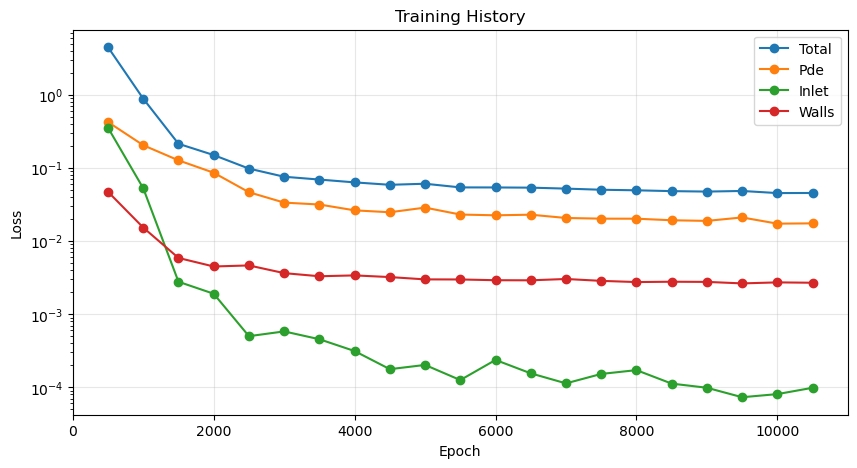

In [15]:
# =============================================================================
# Main
# =============================================================================

def main():
    """Main entry point."""
    # Configuration
    cfg = Config(
        L=2.0,
        H=0.5,
        mu=1.0,
        u_max=1.0,
        layer_sizes=(2, 64, 64, 64, 3),
        n_collocation=2000,
        n_boundary=100,
        n_epochs=10000,
        learning_rate=1e-3,
        w_pde=1.0,
        w_bc=10.0,
        w_inlet=10.0,
        w_outlet=5.0
    )
    
    # Train
    key = random.PRNGKey(42)
    params, history = train(cfg, key)
    
    # Verify
    verify_solution(params, cfg)
    
    # Visualize
    plot_results(params, cfg)
    
    # Plot training history
    if history:
        epochs = [500 * (i + 1) for i in range(len(history))]
        
        fig, ax = plt.subplots(figsize=(10, 5))
        for key in ['total', 'pde', 'inlet', 'walls']:
            values = [h[key] for h in history]
            ax.semilogy(epochs, values, 'o-', label=key.capitalize())
        
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.set_title('Training History')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        plt.savefig('stokes_channel_training.png', dpi=150)
        print("Saved: stokes_channel_training.png")
        plt.show()
    
    return params, history


if __name__ == "__main__":
    """
    Run with:
        pip install jax jaxlib optax matplotlib
        python stokes_channel_pinn.py
    
    Expected outputs:
    1. Training progress showing decreasing loss
    2. Verification results (all tests should PASS):
       - Divergence < 1e-3
       - Wall velocity < 1e-2  
       - Inlet profile error < 1e-2
    3. Visualization showing:
       - Flow from left (inlet) to right (outlet)
       - Parabolic velocity profile
       - Pressure decreasing in flow direction
       - Zero velocity at walls
    """
    params, history = main()